In [1]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau


In [7]:
from tensorflow.keras.utils import to_categorical

# Load the combined dataset
combined_data = pd.read_csv("merged_worm_data.csv")  # Replace with your combined dataset file

columns_to_standardize = ['X', 'Y', 'euclidean_speed', 'roaming_frac', 'std_speed', 'mean_speed', 'speed_variability', 'speed_diff', 'Angular Change', 'Total Distance', 'Instantaneous Distance', 'Changed Pixels', 'Angle', 'speed_change']
combined_data[columns_to_standardize] = (combined_data[columns_to_standardize] - combined_data[columns_to_standardize].mean()) / combined_data[columns_to_standardize].std()

features = ['Frame','X', 'Y', 'Light_Pulse', 'euclidean_speed', 'roaming_frac', 'Angular Change', 'Instantaneous Distance', 'worm_id', 'time_hours', 'Changed Pixels', 'Total Distance', 'Angle', 'mean_speed', 'speed_variability', 'speed_change', 'std_speed']
combined_data = combined_data[features]

combined_data = combined_data.sort_values(by=['worm_id', 'Frame'])
#print(combined_data['euclidean_speed'].isna().sum())  # Outputs the number of NaN values in the 'speed' column
#print(combined_data['Instantaneous Distance'].isna().sum())
combined_data = combined_data.fillna(0)

train_data = combined_data.groupby('worm_id').apply(lambda x: x.iloc[:len(x)//2]).reset_index(drop=True)
test_data = combined_data.groupby('worm_id').apply(lambda x: x.iloc[len(x)//2:]).reset_index(drop=True)

# Separate features and target for training
X_train = train_data.drop(columns=['worm_id', 'Frame'])

y_train = train_data['worm_id']

# Prepare test features (exclude speed for testing)
X_test = test_data.drop(columns=['worm_id', 'Frame'])
y_test = test_data['worm_id']
#mean_speed = y_test.mean()
#print(mean_speed)

y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

print(f"y_train_encoded shape: {y_train_encoded.shape}")
print(f"y_test_encoded shape: {y_test_encoded.shape}")


C:\Users\srush\AppData\Local\Temp\ipykernel_26552\3310866928.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_data = combined_data.groupby('worm_id').apply(lambda x: x.iloc[:len(x)//2]).reset_index(drop=True)
C:\Users\srush\AppData\Local\Temp\ipykernel_26552\3310866928.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_data = combined_data.groupby('worm_id').apply(lambda x: x.iloc[len(x)//2

y_train_encoded shape: (1042523, 18)
y_test_encoded shape: (1042532, 18)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Model definition
model = Sequential()

# Input layer and first convolution layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))

# Additional convolution and pooling layers (if needed, to capture higher-level features)
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Flattening layer to convert 2D output into 1D vector for Dense layers
model.add(Flatten())

# Fully connected layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))  # Dropout for regularization

# Output layer: 18 units for 18 classes (worm IDs), softmax activation for multi-class classification
model.add(Dense(18, activation='softmax'))

early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, min_delta=0.0001)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',     # Monitor validation loss
    factor=0.5,             # Reduce LR by half
    patience=4,             # Wait for 5 epochs without improvement
    min_lr=1e-6,            # Don't reduce LR below this value
    verbose=1               # Print messages when LR is reduced
)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Reshaping input data to be suitable for Conv1D (since it expects a 3D input)
X_train_reshaped = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_reshaped = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)

# Model training
history = model.fit(X_train_reshaped, y_train_encoded, epochs=25, batch_size=32, validation_data=(X_test_reshaped, y_test_encoded), callbacks=[early_stopping, lr_scheduler])

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test_encoded)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')
# Save the model in the TensorFlow SavedModel format
model.save('cnn_model.keras')


c:\Users\srush\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
32579/32579 ━━━━━━━━━━━━━━━━━━━━ 235s 7ms/step - accuracy: 0.7825 - loss: 0.6110 - val_accuracy: 0.8149 - val_loss: 0.8303 - learning_rate: 0.0010
Epoch 2/25
16426/32579 ━━━━━━━━━━━━━━━━━━━━ 1:05 4ms/step - accuracy: 0.9578 - loss: 0.1175

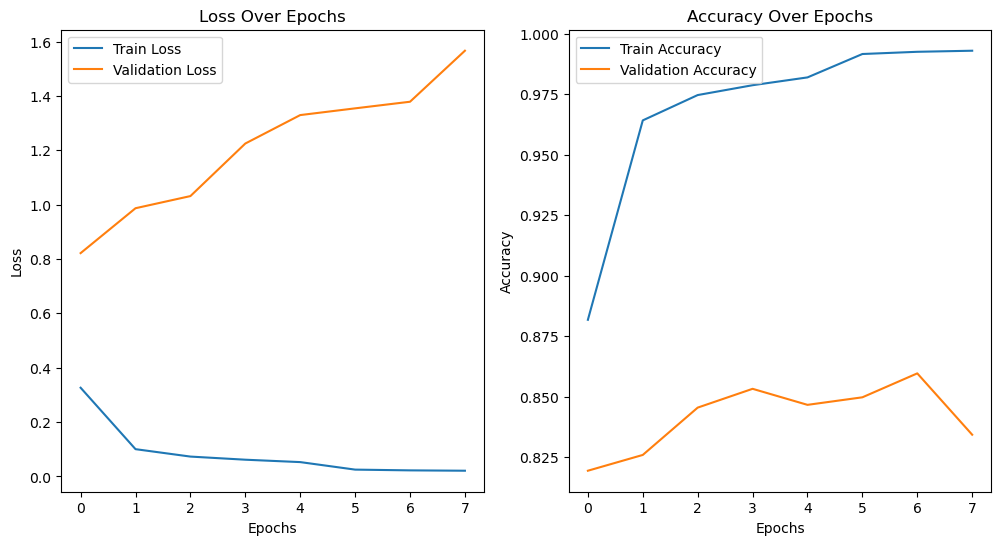

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


32580/32580 ━━━━━━━━━━━━━━━━━━━━ 54s 2ms/step


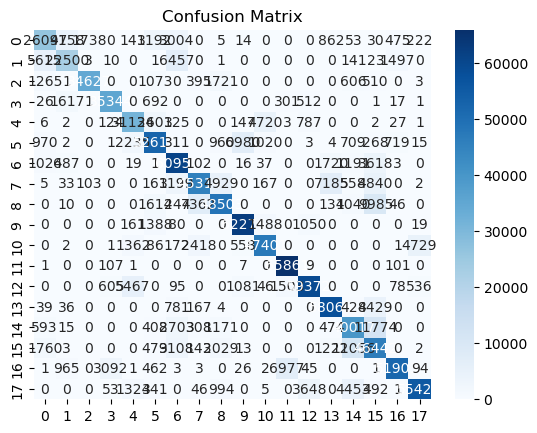

              precision    recall  f1-score   support

           0       0.70      0.65      0.67     39991
           1       0.75      0.62      0.68     36248
           2       0.95      0.86      0.90     40201
           3       0.90      0.92      0.91     38512
           4       0.74      0.78      0.76     39879
           5       0.81      0.79      0.80     66813
           6       0.75      0.88      0.81     69368
           7       0.81      0.68      0.74     66496
           8       0.80      0.70      0.75     68938
           9       0.88      0.94      0.91     66462
          10       0.86      0.84      0.85     56730
          11       0.88      1.00      0.94     66087
          12       0.91      0.86      0.88     68783
          13       0.83      0.91      0.87     63949
          14       0.66      0.70      0.68     57463
          15       0.56      0.70      0.62     66257
          16       0.95      0.82      0.88     63575
          17       0.91    

In [ ]:
# Evaluate the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score


# Make predictions
predictions = model.predict(X_test_reshaped)

# Convert predictions to the class with the highest probability
predicted_classes = np.argmax(predictions, axis=1)


# Convert y_test_encoded back to original class labels
y_test_classes = np.argmax(y_test_encoded, axis=1)

print(classification_report(y_test_classes, predicted_classes))




LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Attention, Input
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import OneHotEncoder
from keras.regularizers import l2
from keras.layers import Lambda

time_steps = 10  # Use 10 past timesteps for prediction

# Function to create sequences of the desired timestep length
def create_sequences(data, time_steps):
    sequences = []
    for i in range(len(data) - time_steps + 1):  # Ensure enough timesteps are available
        sequences.append(data[i:i+time_steps])
    return np.array(sequences)

# Create sequences for training and testing
X_train_LSTM = create_sequences(X_train.to_numpy(), time_steps)
X_test_LSTM = create_sequences(X_test.to_numpy(), time_steps)

y_train_LSTM = y_train_encoded[time_steps - 1:]  # Align targets with the sequence start
y_test_LSTM = y_test_encoded[time_steps - 1:]


# Define EarlyStopping callback to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=10,           # Number of epochs with no improvement
    restore_best_weights=True  # Restore the best model weights
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',     # Monitor validation loss
    factor=0.5,             # Reduce LR by half
    patience=4,             # Wait for 5 epochs without improvement
    min_lr=1e-6,            # Don't reduce LR below this value
    verbose=1               # Print messages when LR is reduced
)

input_layer = Input(shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2]))

# LSTM layer
lstm_out = LSTM(64, return_sequences=True)(input_layer)

# Attention mechanism
attention = Attention()([lstm_out, lstm_out])  # Self-attention: Query=Key=Value=LSTM outputs


# Flatten the attention output
flattened = Lambda(lambda x: tf.reduce_mean(x, axis=1))(attention)  # Aggregate over time steps


# Define the LSTM model
model = Sequential()

# Add LSTM layer (units = number of neurons, input_shape = (timesteps, features))
model.add(LSTM(units=64, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2]), return_sequences=False))

# Optionally add a dropout layer to prevent overfitting
model.add(Dropout(0.2)) #0.5 worse

# Add a dense layer with ReLU activation
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))


# Output layer with softmax activation (for multi-class classification)
model.add(Dense(y_train_encoded.shape[1], activation='softmax'))

# Compile the model with an appropriate loss function and optimizer
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Reshape the data for LSTM input (samples, time steps, features)
#X_train_lstm = X_train_LSTM.reshape(X_train_LSTM.shape[0], X_train_LSTM.shape[1], X_train_LSTM.shape[2])
#X_test_lstm = X_test_LSTM.reshape(X_test_LSTM.shape[0], X_test_LSTM.shape[1], X_test_LSTM.shape[2])

# Train the model with early stopping
history = model.fit(
    X_train_LSTM, 
    y_train_LSTM, 
    epochs=50, 
    batch_size=32,   #128 gave worse results 
    validation_data=(X_test_LSTM, y_test_LSTM),
    callbacks=[early_stopping, lr_scheduler]
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test_LSTM, y_test_LSTM)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


c:\Users\srush\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
32579/32579 ━━━━━━━━━━━━━━━━━━━━ 211s 6ms/step - accuracy: 0.9668 - loss: 0.1712 - val_accuracy: 0.9041 - val_loss: 0.4698 - learning_rate: 0.0010
Epoch 2/50
32579/32579 ━━━━━━━━━━━━━━━━━━━━ 200s 6ms/step - accuracy: 0.9989 - loss: 0.0095 - val_accuracy: 0.9139 - val_loss: 0.5205 - learning_rate: 0.0010
Epoch 3/50
32579/32579 ━━━━━━━━━━━━━━━━━━━━ 209s 6ms/step - accuracy: 0.9992 - loss: 0.0072 - val_accuracy: 0.9004 - val_loss: 0.7017 - learning_rate: 0.0010
Epoch 4/50
32579/32579 ━━━━━━━━━━━━━━━━━━━━ 206s 6ms/step - accuracy: 0.9992 - loss: 0.0071 - val_accuracy: 0.9231 - val_loss: 0.4558 - learning_rate: 0.0010
Epoch 5/50
32579/32579 ━━━━━━━━━━━━━━━━━━━━ 204s 6ms/step - accuracy: 0.9993 - loss: 0.0063 - val_accuracy: 0.9238 - val_loss: 0.4583 - learning_rate: 0.0010
Epoch 6/50
32579/32579 ━━━━━━━━━━━━━━━━━━━━ 413s 13ms/step - accuracy: 0.9993 - loss: 0.0062 - val_accuracy: 0.9289 - val_loss: 0.4031 - learning_rate: 0.0010
Epoch 7/50
32579/32579 ━━━━━━━━━━━━━━━━━━━━ 208s 6m

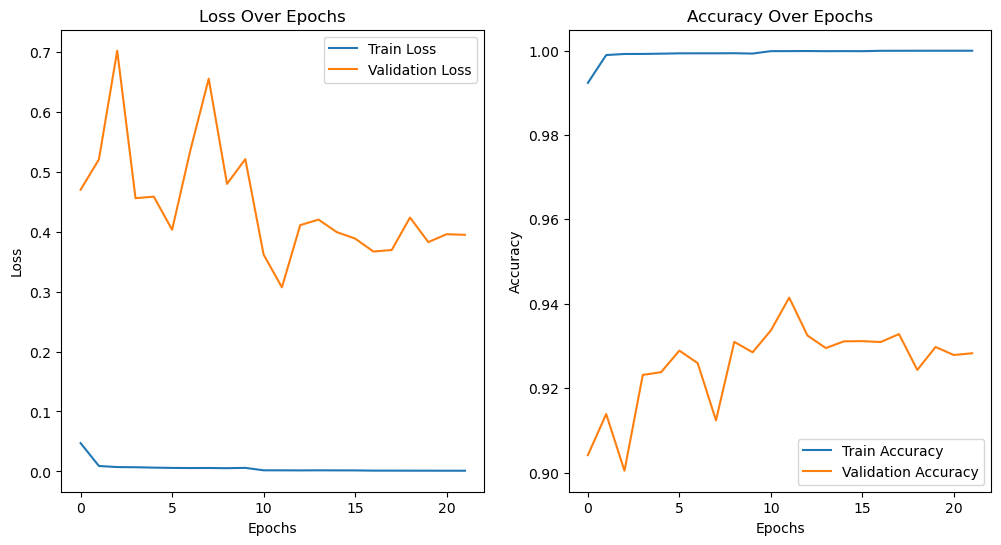

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
# Evaluate the confusion matrix
from sklearn.metrics import classification_report, accuracy_score


# Make predictions
predictions = model.predict(X_test_LSTM)

# Convert predictions to the class with the highest probability
predicted_classes = np.argmax(predictions, axis=1)

'''
cm = confusion_matrix(y_test_LSTM, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()'''

# Convert y_test_encoded back to original class labels
y_test_classes = np.argmax(y_test_LSTM, axis=1)

print(classification_report(y_test_classes, predicted_classes))


32579/32579 ━━━━━━━━━━━━━━━━━━━━ 121s 4ms/step
              precision    recall  f1-score   support

           0       0.82      0.85      0.83     39982
           1       0.89      0.74      0.81     36248
           2       0.95      0.97      0.96     40201
           3       0.97      1.00      0.99     38512
           4       0.96      0.99      0.98     39879
           5       0.97      0.99      0.98     66813
           6       0.97      0.99      0.98     69368
           7       0.98      1.00      0.99     66496
           8       0.92      0.96      0.94     68938
           9       0.97      0.96      0.97     66462
          10       0.95      0.98      0.97     56730
          11       0.87      1.00      0.93     66087
          12       0.97      0.86      0.91     68783
          13       1.00      1.00      1.00     63949
          14       0.81      0.96      0.88     57463
          15       0.92      0.71      0.80     66257
          16       1.00      0.98 

In [ ]:
# Save the model in the Keras format
model.save('lstm_model.keras')


LSTM w/ attention layers

In [ ]:
import numpy as np
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dropout, Attention
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Lambda

time_steps = 10  # Use 10 past timesteps for prediction

# Function to create sequences of the desired timestep length
def create_sequences(data, time_steps):
    sequences = []
    for i in range(len(data) - time_steps + 1):  # Ensure enough timesteps are available
        sequences.append(data[i:i+time_steps])
    return np.array(sequences)

# Create sequences for training and testing
X_train_LSTM = create_sequences(X_train.to_numpy(), time_steps)
X_test_LSTM = create_sequences(X_test.to_numpy(), time_steps)

y_train_LSTM = y_train_encoded[time_steps - 1:]  # Align targets with the sequence start
y_test_LSTM = y_test_encoded[time_steps - 1:]

# Define EarlyStopping and ReduceLROnPlateau callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=7, 
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
    min_lr=1e-6,
    verbose=1
)

# Define the model with attention
input_layer = Input(shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2]))

# LSTM layer
lstm_out = LSTM(64, return_sequences=True)(input_layer)

# Attention mechanism
attention = Attention()([lstm_out, lstm_out])  # Self-attention: Query=Key=Value=LSTM outputs


# Flatten the attention output
flattened = Lambda(lambda x: tf.reduce_mean(x, axis=1))(attention)  # Aggregate over time steps

# Dense layers
dense = Dense(128, activation='relu')(flattened)
dropout = Dropout(0.5)(dense)

# Output layer
output_layer = Dense(y_train_encoded.shape[1], activation='softmax')(dropout)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with early stopping and learning rate scheduler
history = model.fit(
    X_train_LSTM,
    y_train_LSTM,
    epochs=50,
    batch_size=64,
    validation_data=(X_test_LSTM, y_test_LSTM),
    callbacks=[early_stopping, lr_scheduler]
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test_LSTM, y_test_LSTM)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")



Epoch 1/50
16290/16290 ━━━━━━━━━━━━━━━━━━━━ 149s 9ms/step - accuracy: 0.9467 - loss: 0.1714 - val_accuracy: 0.9203 - val_loss: 0.4311 - learning_rate: 0.0010
Epoch 2/50
16290/16290 ━━━━━━━━━━━━━━━━━━━━ 145s 9ms/step - accuracy: 0.9996 - loss: 0.0020 - val_accuracy: 0.9401 - val_loss: 0.4851 - learning_rate: 0.0010
Epoch 3/50
16290/16290 ━━━━━━━━━━━━━━━━━━━━ 144s 9ms/step - accuracy: 0.9996 - loss: 0.0017 - val_accuracy: 0.9171 - val_loss: 0.7601 - learning_rate: 0.0010
Epoch 4/50
16290/16290 ━━━━━━━━━━━━━━━━━━━━ 126s 8ms/step - accuracy: 0.9998 - loss: 8.4785e-04 - val_accuracy: 0.9254 - val_loss: 0.7797 - learning_rate: 0.0010
Epoch 5/50
16284/16290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9999 - loss: 5.9859e-04
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
16290/16290 ━━━━━━━━━━━━━━━━━━━━ 124s 8ms/step - accuracy: 0.9999 - loss: 5.9862e-04 - val_accuracy: 0.9423 - val_loss: 0.4934 - learning_rate: 0.0010
Epoch 6/50
16290/16290 ━━━━━━━━━━━━━━━━━━━

32579/32579 ━━━━━━━━━━━━━━━━━━━━ 79s 2ms/step


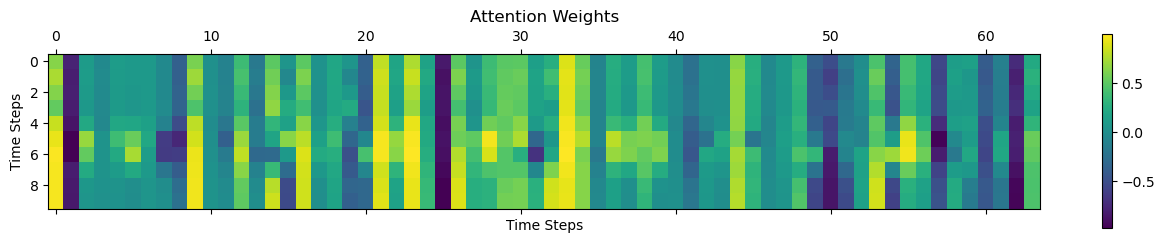

In [ ]:
# Create a model to output attention weights
attention_model = Model(inputs=model.input, outputs=model.get_layer("attention_1").output)
attention_weights = attention_model.predict(X_test_LSTM)

# Visualize attention weights for a sample sequence
import matplotlib.pyplot as plt
plt.matshow(attention_weights[0])  # Visualize the attention weights for the first test sample
plt.title("Attention Weights")
plt.colorbar()
plt.xlabel("Time Steps")
plt.ylabel("Time Steps")
plt.show()


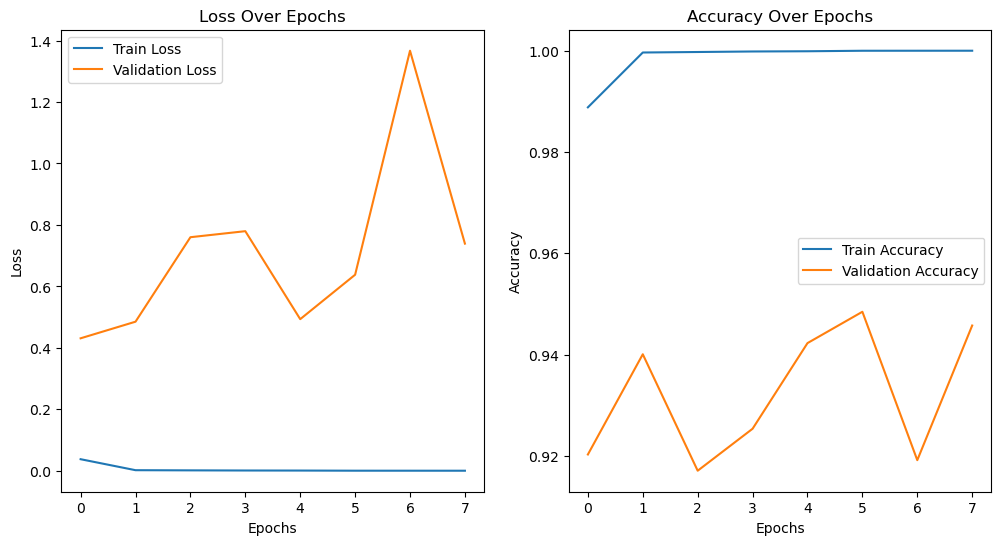

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
%pip freeze


absl-py==2.1.0
aext-assistant @ file:///C:/b/abs_7e0qjcige6/croot/aext-assistant_1717062202219/work
aext-assistant-server @ file:///C:/b/abs_261y2c9vsm/croot/aext-assistant-server_1717060019302/work
aext-core @ file:///C:/b/abs_1e882xlg8y/croot/aext-core_1717056431204/work
aext-core-server @ file:///C:/b/abs_24av6ljtvu/croot/aext-core-server_1717075079138/work
aext-panels @ file:///C:/b/abs_44bc4hv663/croot/aext-panels_1717062218055/work
aext-panels-server @ file:///C:/b/abs_7f9_48fhp3/croot/aext-panels-server_1717060738001/work
aext-share-notebook @ file:///C:/b/abs_4bhc14ko2x/croot/aext-share-notebook_1717059348177/work
aext-share-notebook-server @ file:///C:/b/abs_2b3c16a8t0/croot/aext-share-notebook-server_1717057990383/work
aext-shared @ file:///C:/b/abs_1ex0tj8g9m/croot/aext-shared_1716991146845/work
aiobotocore @ file:///C:/b/abs_a0zxrsvpwx/croot/aiobotocore_1714464454692/work
aiohappyeyeballs @ file:///C:/b/abs_b505trsapr/croot/aiohappyeyeballs_1725434036096/work
aiohttp @ file